#                          Analysis of Real Estate Sales in Conneticut 

##### Collaborators: Arin Zeng, Helen Gu, Jennifer Li, Jason Chen
<hr>

# Introduction

The main purpose of this project is to take you through the entire pipeline of a data science journey. We will focus on how unemployment rates, interest rates, location, among other factors, affect the sales ratio of real estate homes in Connecticut. Amidst a nation where the population is rapidly growing, homes and other real-estate properties are increasing in demand while becoming a more popular investment area. The real-estate market can appear to be a world of mystery, and intimidating to navigate. As a home-buyer, you want to understand the factors to weigh in to purchase or invest in real-estate; as a home-seller, you want to understand the factors to weigh in to sell your real-estate. We want to appeal to these two audiences in particular, as we work to uncover the mystery surrounding the real-estate market. We will be focusing on data sets specific to Connecticut, but our tutorial will easily be applicable to studying the real-estate market in other states. 


The purpose of this tutorial is to analyze factors that affect sales ratio in the real-estate market, and examine its relationship with real-estate sales and profits. We will explore various methods of graphing and visualizing possible relationships and trends in the data to better understand the factors that impact the real-estate market. Data science is a perfect tool for this task because it allows us to easily unpack and organize messy and complicated data to synthesize more digestible descriptions of the real-estate market that market participants can refer to in their daily decisions.

### Imports

In [65]:
# import necessary libraries
import pandas as pd
from sodapy import Socrata
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Data Collection                                

!! Only run once !! <br>
!! Start !!

In [ ]:
#!/usr/bin/env python

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.ct.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.ct.gov,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("5mzw-sjtu", limit=1000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df.head()

Since the original dataset consists of over 990k data points, the data takes too long to filter and process, so we chose to take a random sampling of the data by selecting every hundredth row in order to reduce the size of the dataset.

In [329]:
df = results_df.iloc[::100]
df.to_csv("conn_real_estate_sample.csv", index=False)

!! End !!

In [66]:
results_df = pd.read_csv("data/conn_real_estate_sample.csv")

We want to clean our data and drop any unecessary columns such as serial number, computed regions, and both remarks columns. We also want to truncate the date to only show the calendar date.

In [67]:
df = results_df.drop(columns = ['serialnumber', 
                      ':@computed_region_dam5_q64j', ':@computed_region_nhmp_cq6b', 
                      ':@computed_region_m4y2_whse', ':@computed_region_snd5_k6zv',
                     'remarks', 'opm_remarks'])

df['daterecorded'] = df['daterecorded'].str[:10]
df['Year'] = pd.to_datetime(df['daterecorded'], format="%Y-%m-%d").dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['daterecorded'], format="%Y-%m-%d").dt.strftime('%m')
df

listyear daterecorded       town              address  assessedvalue   
0         2020   2020-10-05    Andover          303 LAKE RD         121300  \
1         2020   2020-11-25    Ansonia    7 JASON WRIGHT DR         172500   
2         2020   2021-05-25    Ansonia       8 BERKSHIRE RD         108300   
3         2020   2021-09-21    Ansonia       5 BIRCHWOOD DR         203700   
4         2020   2020-10-23       Avon       21 CLIFF DRIVE         155390   
...        ...          ...        ...                  ...            ...   
7071      2001   2001-10-05   Woodbury     57 OLD GRASSY HL         190630   
7072      2001   2002-04-02   Woodbury  86 29 WASHINGTON RD          36580   
7073      2001   2002-07-19   Woodbury       58 SHERMAN HTS          96370   
7074      2001   2001-12-31  Woodstock     12 WAINWRIGHT DR          67930   
7075      2001   2002-08-07  Woodstock           564 RT 198         117550   

      saleamount  salesratio propertytype residentialtype   
0       210000.0    0.577600  Residential   Single Family  \
1       330000.0    0.522700  Residential   Single Family   
2       245000.0    0.442000  Residential   Single Family   
3       335000.0    0.608000  Residential   Single Family   
4       249000.0    0.624000  Residential   Single Family   
...          ...         ...          ...             ...   
7071    418962.0    0.455005          NaN             NaN   
7072     80000.0    0.457250          NaN             NaN   
7073    240000.0    0.401542          NaN             NaN   
7074    146000.0    0.465274          NaN             NaN   
7075    199500.0    0.589223          NaN             NaN   

                                        geo_coordinates  nonusecode  Year   
0     {'type': 'Point', 'coordinates': [-72.35327, 4...         NaN  2020  \
1                                                   NaN         NaN  2020   
2                                                   NaN         NaN  2021   
3                                                   NaN         NaN  2021   
4     {'type': 'Point', 'coordinates': [-72.87619, 4...         NaN  2020   
...                                                 ...         ...   ...   
7071                                                NaN         NaN  2001   
7072                                                NaN         NaN  2002   
7073                                                NaN         NaN  2002   
7074                                                NaN         NaN  2001   
7075  {'type': 'Point', 'coordinates': [-72.07593, 4...         NaN  2002   

     Month  
0       10  
1       11  
2       05  
3       09  
4       10  
...    ...  
7071    10  
7072    04  
7073    07  
7074    12  
7075    08  

[7076 rows x 13 columns]

## Step 2: Data Processing

We want to split the geographic coordinates into separate x and y coordinates.

In [68]:
df['coord'] = df['geo_coordinates'].astype(str).str.extract('\[(.*?)\]', expand=False).str.strip()
df[['x_coord','y_coord']] = df.coord.str.split(", ",expand=True).astype(float)
df = df.drop(columns = ['geo_coordinates', 'coord'])
df.head()

listyear daterecorded     town            address  assessedvalue   
0      2020   2020-10-05  Andover        303 LAKE RD         121300  \
1      2020   2020-11-25  Ansonia  7 JASON WRIGHT DR         172500   
2      2020   2021-05-25  Ansonia     8 BERKSHIRE RD         108300   
3      2020   2021-09-21  Ansonia     5 BIRCHWOOD DR         203700   
4      2020   2020-10-23     Avon     21 CLIFF DRIVE         155390   

   saleamount  salesratio propertytype residentialtype  nonusecode  Year   
0    210000.0      0.5776  Residential   Single Family         NaN  2020  \
1    330000.0      0.5227  Residential   Single Family         NaN  2020   
2    245000.0      0.4420  Residential   Single Family         NaN  2021   
3    335000.0      0.6080  Residential   Single Family         NaN  2021   
4    249000.0      0.6240  Residential   Single Family         NaN  2020   

  Month   x_coord   y_coord  
0    10 -72.35327  41.71416  
1    11       NaN       NaN  
2    05       NaN       NaN  
3    09       NaN       NaN  
4    10 -72.87619  41.80986

In [69]:
df.describe()

listyear  assessedvalue    saleamount   salesratio  nonusecode   
count  7076.000000   7.076000e+03  7.076000e+03  7076.000000         0.0  \
mean   2009.954211   2.306462e+05  3.838914e+05     0.606059         NaN   
std       6.366022   4.231461e+05  7.206351e+05     0.195015         NaN   
min    2001.000000   0.000000e+00  0.000000e+00     0.000000         NaN   
25%    2004.000000   9.281500e+04  1.670000e+05     0.485414         NaN   
50%    2009.000000   1.449950e+05  2.470000e+05     0.597535         NaN   
75%    2016.000000   2.329325e+05  3.821250e+05     0.704150         NaN   
max    2020.000000   1.540000e+07  2.489893e+07     7.915833         NaN   

           x_coord      y_coord  
count  1403.000000  1403.000000  
mean    -72.887949    41.485677  
std       0.428388     0.258001  
min     -73.671740    41.012320  
25%     -73.221735    41.280930  
50%     -72.907140    41.483920  
75%     -72.634795    41.709425  
max     -71.810420    42.033330

Based on the summary description of the data, there is a sales ratio value that lies far beyond the rest of the values. Since the max value of 7.915 is greater than the third quartile + 1.5*IQR which is equal to 0.70 + 1.5(0.70 - 0.49) = 1.015, then it is evident that this data point is an outlier so we can remove it from the dataset and filter out unreasonably high values.

In [70]:
df = df[df['salesratio'] < 2]
df

listyear daterecorded       town              address  assessedvalue   
0         2020   2020-10-05    Andover          303 LAKE RD         121300  \
1         2020   2020-11-25    Ansonia    7 JASON WRIGHT DR         172500   
2         2020   2021-05-25    Ansonia       8 BERKSHIRE RD         108300   
3         2020   2021-09-21    Ansonia       5 BIRCHWOOD DR         203700   
4         2020   2020-10-23       Avon       21 CLIFF DRIVE         155390   
...        ...          ...        ...                  ...            ...   
7071      2001   2001-10-05   Woodbury     57 OLD GRASSY HL         190630   
7072      2001   2002-04-02   Woodbury  86 29 WASHINGTON RD          36580   
7073      2001   2002-07-19   Woodbury       58 SHERMAN HTS          96370   
7074      2001   2001-12-31  Woodstock     12 WAINWRIGHT DR          67930   
7075      2001   2002-08-07  Woodstock           564 RT 198         117550   

      saleamount  salesratio propertytype residentialtype  nonusecode  Year   
0       210000.0    0.577600  Residential   Single Family         NaN  2020  \
1       330000.0    0.522700  Residential   Single Family         NaN  2020   
2       245000.0    0.442000  Residential   Single Family         NaN  2021   
3       335000.0    0.608000  Residential   Single Family         NaN  2021   
4       249000.0    0.624000  Residential   Single Family         NaN  2020   
...          ...         ...          ...             ...         ...   ...   
7071    418962.0    0.455005          NaN             NaN         NaN  2001   
7072     80000.0    0.457250          NaN             NaN         NaN  2002   
7073    240000.0    0.401542          NaN             NaN         NaN  2002   
7074    146000.0    0.465274          NaN             NaN         NaN  2001   
7075    199500.0    0.589223          NaN             NaN         NaN  2002   

     Month   x_coord   y_coord  
0       10 -72.35327  41.71416  
1       11       NaN       NaN  
2       05       NaN       NaN  
3       09       NaN       NaN  
4       10 -72.87619  41.80986  
...    ...       ...       ...  
7071    10       NaN       NaN  
7072    04       NaN       NaN  
7073    07       NaN       NaN  
7074    12       NaN       NaN  
7075    08 -72.07593  41.95063  

[7075 rows x 14 columns]

### Analysis of Interest Rates

In [71]:
url = "https://www.firstrepublic.com/finmkts/historical-interest-rates"

# initiating the webdriver. Parameter includes the path of the webdriver.
driver = webdriver.Chrome('./chromedriver') 
driver.get(url) 
  
# this is just to ensure that the page is loaded
time.sleep(5) 
  
html = driver.page_source
  
# this renders the JS code and stores all
# of the information in static HTML code.
  
# Now, we could simply apply bs4 to html variable
soup = BeautifulSoup(html, "html.parser")

/var/folders/04/hdjfckkd4fd__5521d_kggjh0000gn/T/ipykernel_53103/1535766723.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


WebDriverException: Message: unknown error: cannot find Chrome binary
Stacktrace:
0   chromedriver                        0x000000010042b8ac chromedriver + 4257964
1   chromedriver                        0x0000000100423f40 chromedriver + 4226880
2   chromedriver                        0x00000001000609d4 chromedriver + 281044
3   chromedriver                        0x0000000100087778 chromedriver + 440184
4   chromedriver                        0x0000000100085c38 chromedriver + 433208
5   chromedriver                        0x00000001000c33dc chromedriver + 685020
6   chromedriver                        0x00000001000c2c08 chromedriver + 683016
7   chromedriver                        0x000000010008f98c chromedriver + 473484
8   chromedriver                        0x000000010009098c chromedriver + 477580
9   chromedriver                        0x00000001003ea900 chromedriver + 3991808
10  chromedriver                        0x00000001003ee354 chromedriver + 4006740
11  chromedriver                        0x00000001003ee940 chromedriver + 4008256
12  chromedriver                        0x00000001003f433c chromedriver + 4031292
13  chromedriver                        0x00000001003eef34 chromedriver + 4009780
14  chromedriver                        0x00000001003c7490 chromedriver + 3847312
15  chromedriver                        0x000000010040c9f4 chromedriver + 4131316
16  chromedriver                        0x000000010040cb4c chromedriver + 4131660
17  chromedriver                        0x000000010041d230 chromedriver + 4198960
18  libsystem_pthread.dylib             0x000000018708826c _pthread_start + 148
19  libsystem_pthread.dylib             0x000000018708308c thread_start + 8


In [72]:
table = soup.find_all("table")
# print(table[2])
arr = str(table[2]).split("<tbody>")
arr = arr[1].split("\n")
arr = arr[-2].split("<tr>")
arr = arr[1:]

df1 = pd.DataFrame(arr)

for i, row in df1.iterrows():
    arr = row[0].split("<td>")
    date = arr[1][:-5]
    if date[-4:] == '2000':
        break
    
    prime_rate = float(arr[4][:-11])
    df1.at[i, 'Year'] = pd.to_datetime(date, format="%m/%Y").year
    df1.at[i, 'Month'] = pd.to_datetime(date, format="%m/%Y").month

    df1.at[i, 'primeRate'] = prime_rate

df1.dropna(inplace=True)
df1.drop(columns=[0], inplace=True)
df1['Year'] = df1['Year'].astype(int)
df1['Month'] = df1['Month'].astype(int)

df_rate = df1.copy()
df_rate.to_csv("data/conn_interest_rate.csv", index=False)
df_rate



NameError: name 'soup' is not defined

In [73]:
# if web driver error
df_rate = pd.read_csv("data/conn_interest_rate.csv")

### Analysis of unemployment rates

In [74]:
unemployment_df = pd.read_csv("data/conn_unemployment.csv")
unemployment_df.head()

Year  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
0  2001  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.0  3.1  3.3  3.4  3.5
1  2002  3.6  3.8  3.9  4.1  4.2  4.3  4.5  4.6  4.8  4.9  5.0  5.1
2  2003  5.2  5.3  5.4  5.5  5.5  5.6  5.6  5.6  5.5  5.5  5.4  5.3
3  2004  5.3  5.3  5.2  5.2  5.2  5.1  5.1  5.0  5.0  4.9  4.9  4.9
4  2005  4.9  4.9  4.9  4.9  4.8  4.8  4.8  4.8  4.8  4.7  4.7  4.6

Looking at the data, the current unemployment data is not tidy, we want to use melting so that we have the year, month, and unemployment rate as columns.

In [75]:
unemployment_df.columns

Index(['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'],
      dtype='object')

In [76]:
unemployment_df = pd.melt(unemployment_df, 
        id_vars=['Year'], 
        value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                    'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        var_name='Month', 
        value_name='UnemploymentRate')

unemployment_df.dropna(inplace=True)
unemployment_df.head()


Year Month  UnemploymentRate
0  2001   Jan               2.3
1  2002   Jan               3.6
2  2003   Jan               5.2
3  2004   Jan               5.3
4  2005   Jan               4.9

In [77]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                    'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, row in unemployment_df.iterrows():
    unemployment_df.at[i, 'Year'] = pd.to_datetime(row['Year'], format="%Y").year
    unemployment_df.at[i, 'Month'] = pd.to_datetime((int(months.index(row['Month'])) + 1), format="%m").month
    # unemployment_df.at[i, 'Month'] = (int(months.index(row['Month'])) + 1)

unemployment_df.head()

Year Month  UnemploymentRate
0  2001     1               2.3
1  2002     1               3.6
2  2003     1               5.2
3  2004     1               5.3
4  2005     1               4.9

In [78]:
df.dtypes

listyear             int64
daterecorded        object
town                object
address             object
assessedvalue        int64
saleamount         float64
salesratio         float64
propertytype        object
residentialtype     object
nonusecode         float64
Year                object
Month               object
x_coord            float64
y_coord            float64
dtype: object

In [79]:
unemployment_df.dtypes

Year                  int64
Month                object
UnemploymentRate    float64
dtype: object

In [80]:
# unemployment_df['Year'] = unemployment_df['Year'].astype(object)
df_copy = df.copy().dropna(subset=['Year', 'Month'])
df_copy['Year'] = df_copy['Year'].astype(int)
df_copy['Month'] = df_copy['Month'].astype(int)


df_merge = pd.merge(df_copy, unemployment_df, on=['Year', 'Month'])
df_merge

listyear daterecorded          town               address   
0         2020   2020-10-05       Andover           303 LAKE RD  \
1         2020   2020-10-23          Avon        21 CLIFF DRIVE   
2         2020   2020-10-09  Beacon Falls       19 SUSAN STREET   
3         2020   2020-10-13        Bethel    57 CHESTNUT STREET   
4         2020   2020-10-21      Branford        2E ANCHOR REEF   
...        ...          ...           ...                   ...   
7069      2001   2002-03-20    Torrington  616 MIGEON AVE UT 10   
7070      2001   2002-03-25      Trumbull       6 PEPPERIDGE RD   
7071      2001   2002-03-01      Westport       92 NEWTOWN TPKE   
7072      2001   2002-03-11  Wethersfield          703 RIDGE RD   
7073      2001   2002-03-27    Woodbridge   27 RICHARD SWEET DR   

      assessedvalue  saleamount  salesratio propertytype residentialtype   
0            121300    210000.0    0.577600  Residential   Single Family  \
1            155390    249000.0    0.624000  Residential   Single Family   
2             32640     45000.0    0.725300  Residential   Single Family   
3            194110    365000.0    0.531800  Residential   Single Family   
4            256000    480000.0    0.533300  Residential           Condo   
...             ...         ...         ...          ...             ...   
7069          17100     32900.0    0.519757          NaN             NaN   
7070         168500    309900.0    0.543724          NaN             NaN   
7071         385900    635000.0    0.607717          NaN             NaN   
7072         131400    245000.0    0.536327          NaN             NaN   
7073         307650    439000.0    0.700797          NaN             NaN   

      nonusecode  Year Month   x_coord   y_coord  UnemploymentRate  
0            NaN  2020    10 -72.35327  41.71416               7.9  
1            NaN  2020    10 -72.87619  41.80986               7.9  
2            NaN  2020    10       NaN       NaN               7.9  
3            NaN  2020    10 -73.40632  41.36916               7.9  
4            NaN  2020    10 -72.67344  41.72606               7.9  
...          ...   ...   ...       ...       ...               ...  
7069         NaN  2002     3       NaN       NaN               3.9  
7070         NaN  2002     3       NaN       NaN               3.9  
7071         NaN  2002     3       NaN       NaN               3.9  
7072         NaN  2002     3       NaN       NaN               3.9  
7073         NaN  2002     3       NaN       NaN               3.9  

[7074 rows x 15 columns]

In [81]:
df_merge = pd.merge(df_merge, df_rate, on=['Year', 'Month'])
df_merge

listyear daterecorded          town               address   
0         2020   2020-10-05       Andover           303 LAKE RD  \
1         2020   2020-10-23          Avon        21 CLIFF DRIVE   
2         2020   2020-10-09  Beacon Falls       19 SUSAN STREET   
3         2020   2020-10-13        Bethel    57 CHESTNUT STREET   
4         2020   2020-10-21      Branford        2E ANCHOR REEF   
...        ...          ...           ...                   ...   
7069      2001   2002-03-20    Torrington  616 MIGEON AVE UT 10   
7070      2001   2002-03-25      Trumbull       6 PEPPERIDGE RD   
7071      2001   2002-03-01      Westport       92 NEWTOWN TPKE   
7072      2001   2002-03-11  Wethersfield          703 RIDGE RD   
7073      2001   2002-03-27    Woodbridge   27 RICHARD SWEET DR   

      assessedvalue  saleamount  salesratio propertytype residentialtype   
0            121300    210000.0    0.577600  Residential   Single Family  \
1            155390    249000.0    0.624000  Residential   Single Family   
2             32640     45000.0    0.725300  Residential   Single Family   
3            194110    365000.0    0.531800  Residential   Single Family   
4            256000    480000.0    0.533300  Residential           Condo   
...             ...         ...         ...          ...             ...   
7069          17100     32900.0    0.519757          NaN             NaN   
7070         168500    309900.0    0.543724          NaN             NaN   
7071         385900    635000.0    0.607717          NaN             NaN   
7072         131400    245000.0    0.536327          NaN             NaN   
7073         307650    439000.0    0.700797          NaN             NaN   

      nonusecode  Year Month   x_coord   y_coord  UnemploymentRate  primeRate  
0            NaN  2020    10 -72.35327  41.71416               7.9       3.25  
1            NaN  2020    10 -72.87619  41.80986               7.9       3.25  
2            NaN  2020    10       NaN       NaN               7.9       3.25  
3            NaN  2020    10 -73.40632  41.36916               7.9       3.25  
4            NaN  2020    10 -72.67344  41.72606               7.9       3.25  
...          ...   ...   ...       ...       ...               ...        ...  
7069         NaN  2002     3       NaN       NaN               3.9       4.75  
7070         NaN  2002     3       NaN       NaN               3.9       4.75  
7071         NaN  2002     3       NaN       NaN               3.9       4.75  
7072         NaN  2002     3       NaN       NaN               3.9       4.75  
7073         NaN  2002     3       NaN       NaN               3.9       4.75  

[7074 rows x 16 columns]

## Step 3: Exploratory Analysis & Data Visualization

First, We will create a dataframe that shows the number of each residential type for each town

In [82]:
# Making a df that shows the amount of each residential type for each town where each column is a
# residential type and another column for the town 

# Listing the Columns in our Dataframe


cleanedList = [x for x in results_df.residentialtype.unique() if x == x]


# First I will create a dataframe for each town

# agg_functions = {'town': 'first', 'residentialtype': 'first'}
residential_df = results_df[['town','residentialtype']]
count_resident_df = residential_df.groupby(['town','residentialtype']).size().reset_index(name='count')


residential_df = count_resident_df.pivot_table(values='count', index='town', columns='residentialtype',fill_value=0)

print(residential_df)


residentialtype  Condo  Four Family  Single Family  Three Family  Two Family
town                                                                        
Andover              0            0              4             0           0
Ansonia              0            0             17             2           1
Ashford              0            0              4             0           1
Avon                11            0             29             0           0
Barkhamsted          0            0              1             0           0
...                ...          ...            ...           ...         ...
Windsor Locks        6            0             11             0           0
Wolcott              1            0              9             0           0
Woodbridge           0            0             13             0           0
Woodbury             5            0              6             0           0
Woodstock            0            0             12             0           0

Now that we've organized this data to show the number of each residence types for each town, let's graph it to 
better visualize and understand what we can observe.

We will first create a bar graph of for each of the resident types showing which town purchased the most 
real estate and showing the most popular residence type. 



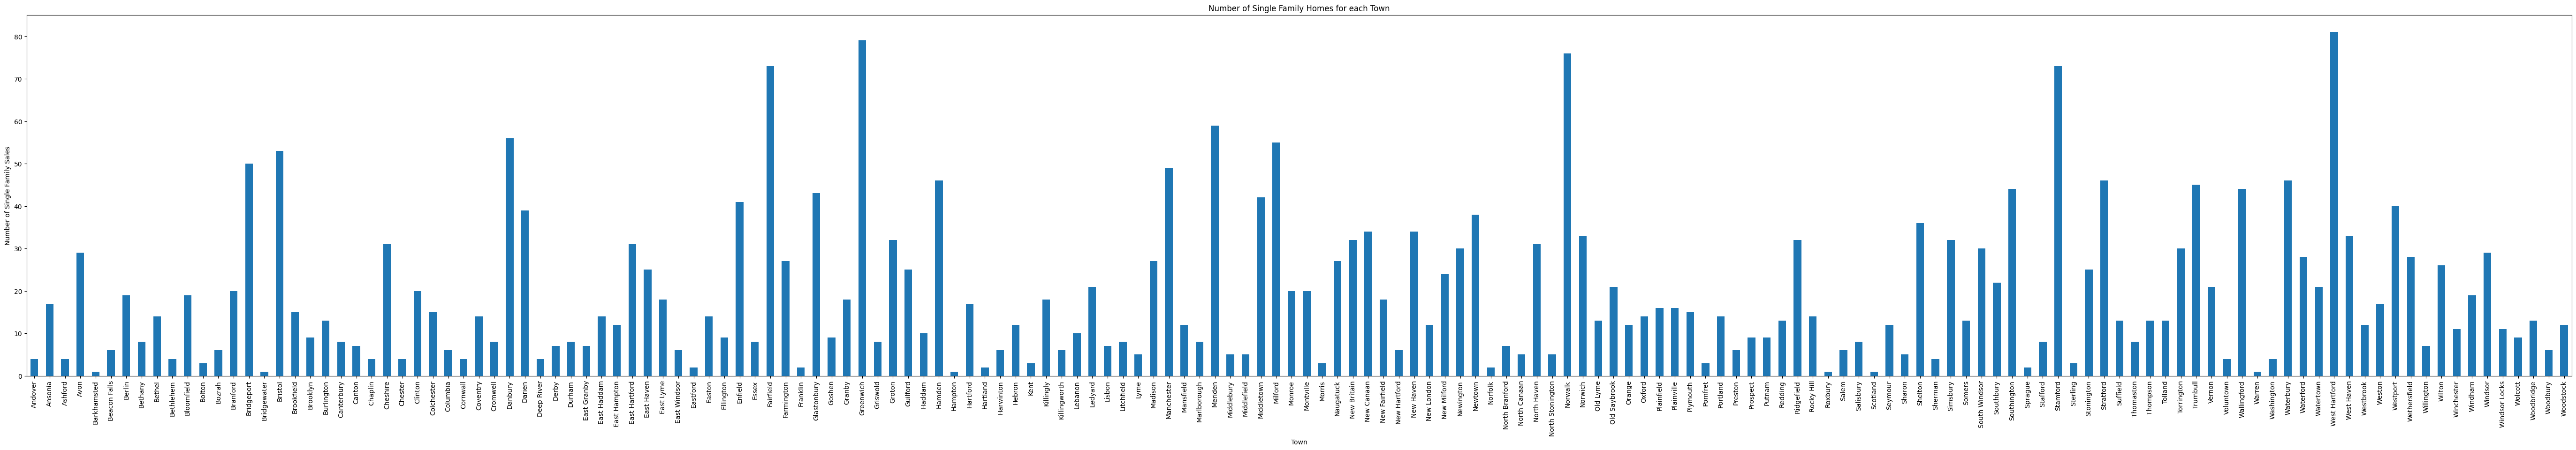

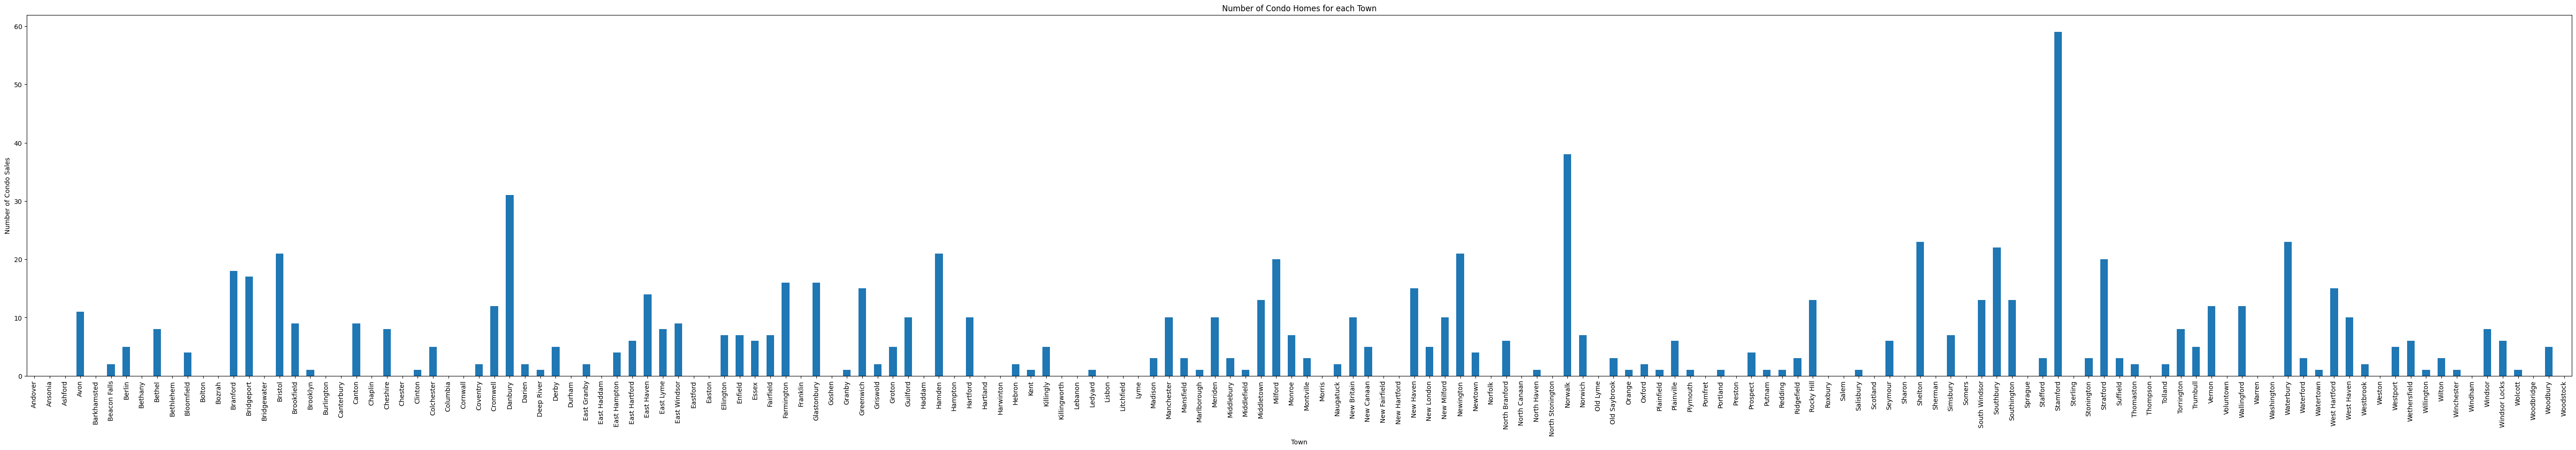

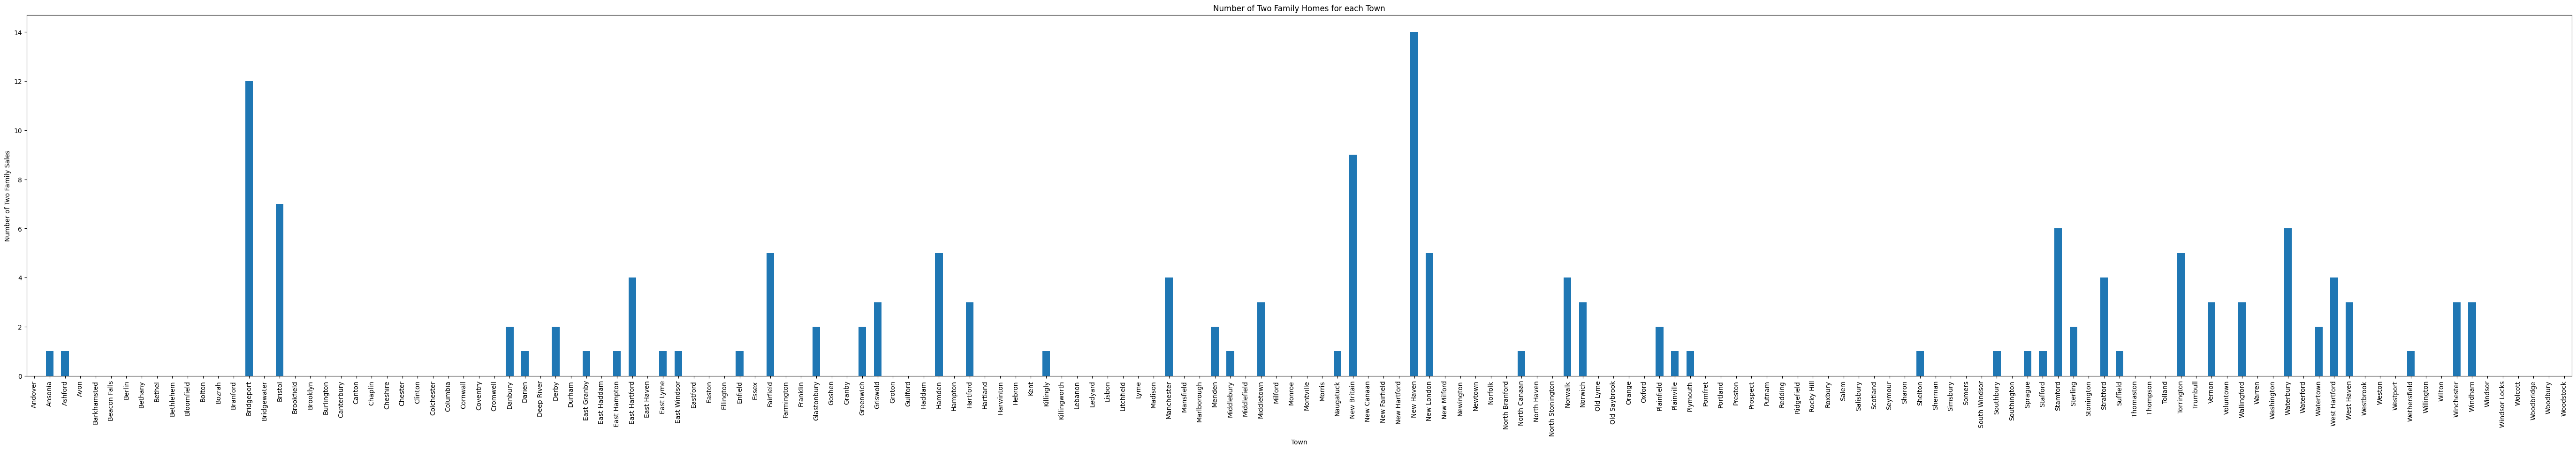

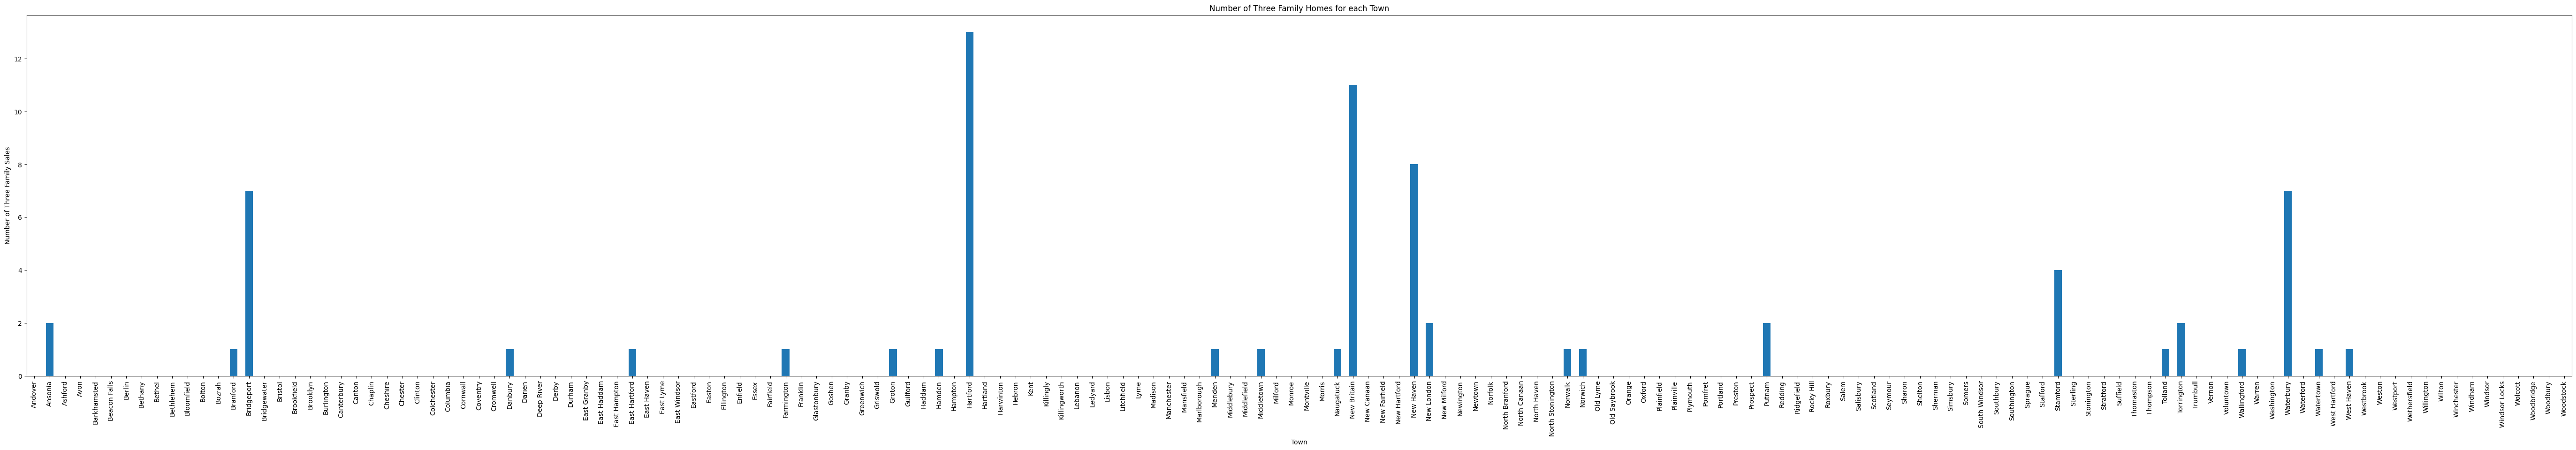

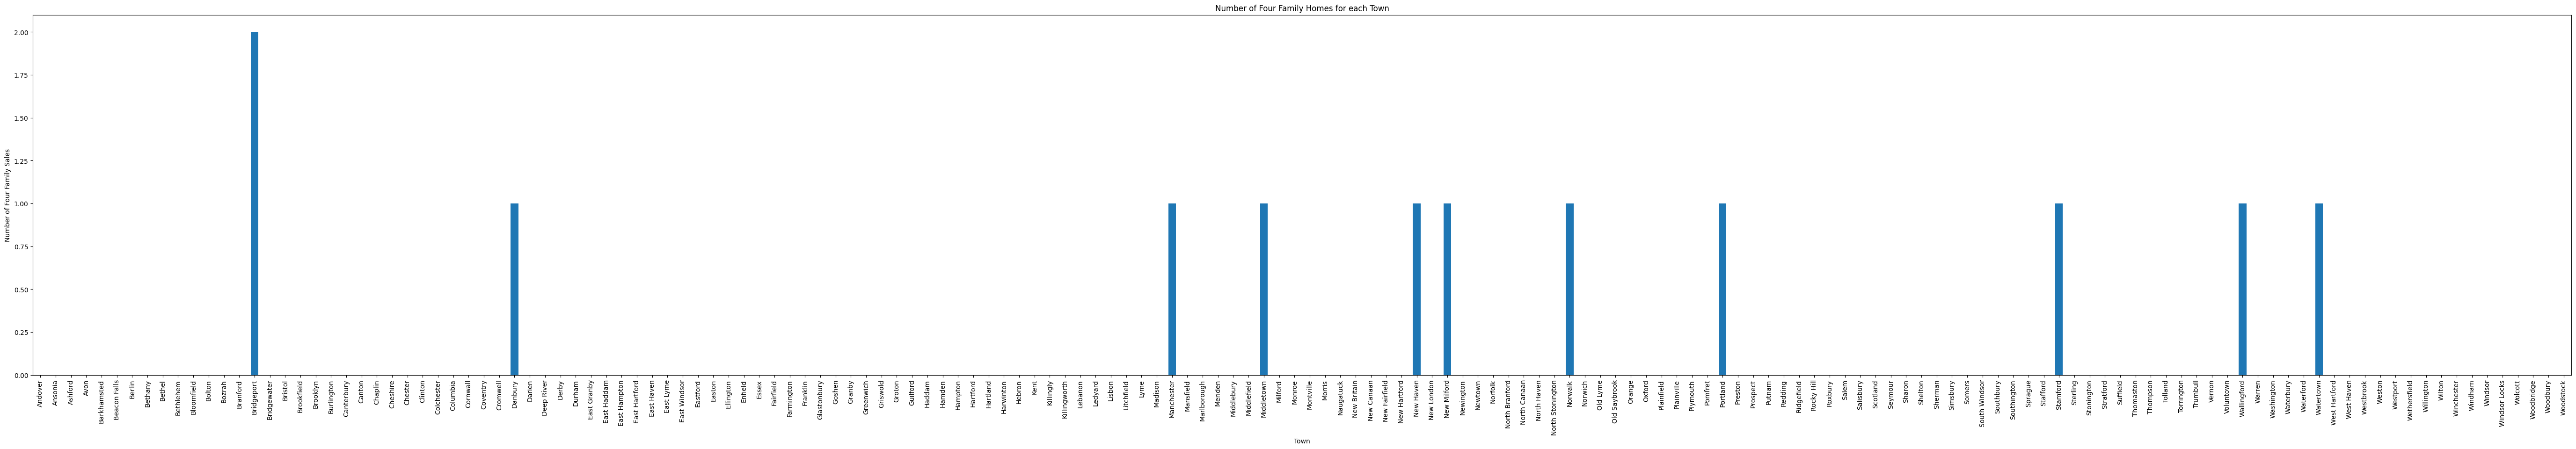

In [83]:
for type in cleanedList:
    temp_df = residential_df[type]
    # Turn on the grid
    temp_df.plot.bar(figsize=(70,10), title='Number of ' + type + ' Homes for each Town')
    plt.xlabel('Town')
    plt.ylabel('Number of ' + type + ' Sales')
    plt.show()

We can observe from each of these graphs the towns with the highest amount of Single Family, Two Family, Condo, Four Family, and  Three Family are Waterbury, Bridgeport, Stamford, Killingly, and Waterbury respectively. 


Next, We will create a pie chart to help us see the the proportion of each home type across all the towns.


0            Condo
1      Four Family
2    Single Family
3     Three Family
4       Two Family
Name: residentialtype, dtype: object


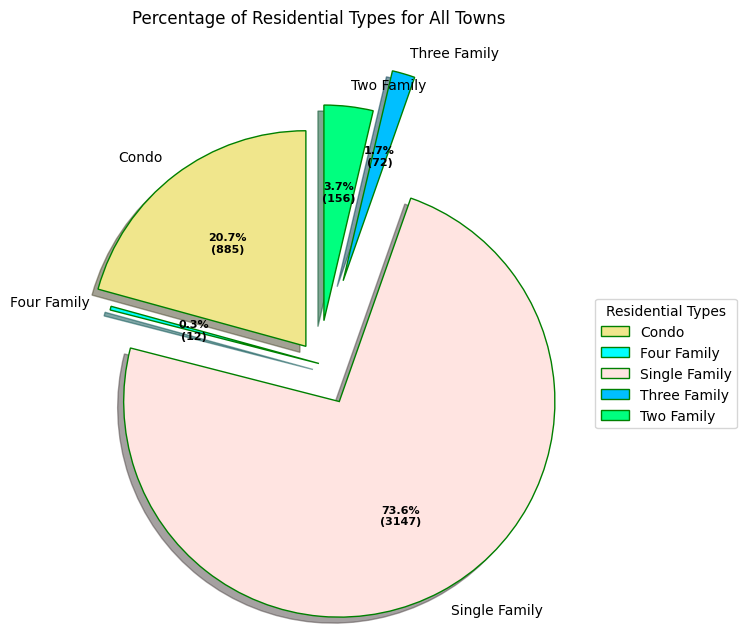

In [84]:

res_type_df= results_df.groupby('residentialtype').first()
res_type_df['COUNT'] = results_df['residentialtype'].value_counts()
res_type_df.reset_index(inplace=True)
res_type_df= res_type_df[['residentialtype','COUNT']]
print(res_type_df['residentialtype'])
"""
data = res_type_df['COUNT'].values.tolist()
types = res_type_df['residentialtype'].values.tolist()
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = types)
 
# show plot
plt.show()"""
explode = (0.1, 0.0, 0.2, 0.4, 0.2)
 
# Creating color parameters
colors = ( "khaki", "cyan", "mistyrose",
          "deepskyblue", "springgreen")
data = res_type_df['COUNT'].values.tolist()
types = res_type_df['residentialtype'].values.tolist()

wp = { 'linewidth' : 1, 'edgecolor' : "green" }

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = types,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, types,
          title ="Residential Types",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Percentage of Residential Types for All Towns\n\n\n")
 
# show plot
plt.show()

We can also observe that the least popular type of home sale was Four Family Homes, accounting for only 0.3% of the total sales, and the most popular type of home sale was Single Family Homes, accounting for 73.6% of total
sales.


Next, we graphed each unique town with its average assessed value of houses, to get an overall assessment of the average value of homes as seen from their assessed amount in each town.

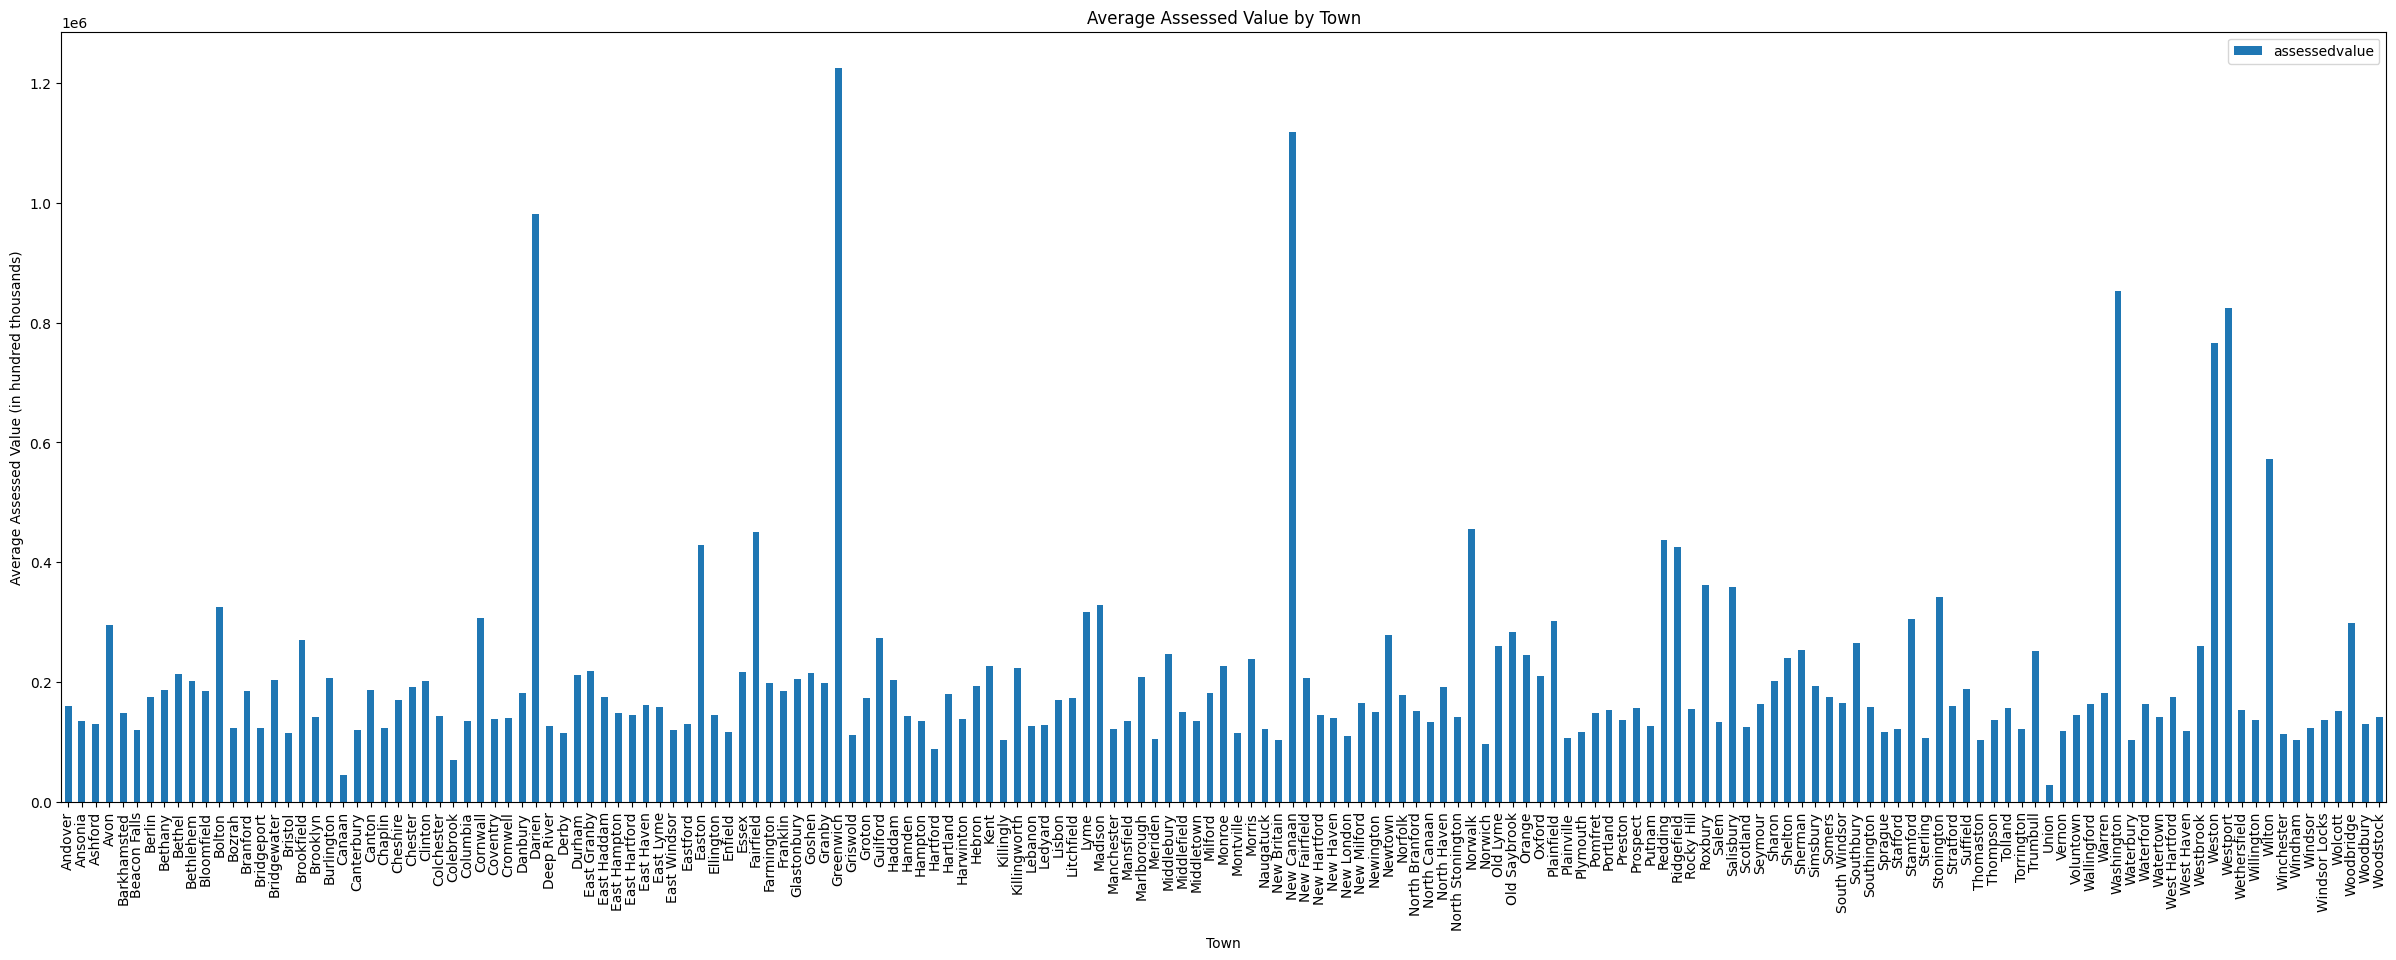

In [85]:
# make table with just town and assessedvalue columns
df2 = df_merge[['town', 'assessedvalue']]

# group by town and average the assessedvalue
df2 = df2.groupby('town').mean()

# remove the rows where town is '***Unknown***'
df2 = df2[df2.index != '***Unknown***']

df2.head()

# bar graph with town vs assessedvalue
df2.plot.bar(figsize=(30,10), title='Average Assessed Value by Town')
plt.xlabel('Town')
plt.ylabel('Average Assessed Value (in hundred thousands)')
plt.show()

As we can see from the bar graph above, the average assessed value for homes in most towns is within the ranges of $150,000 and $300,000. From this graph, we can also observe that there are towns with a signficantly higher average assessed value of homes, such as Darien, Greenwich, New Canaan, etc.

Next, we graphed each unique town with its average sale amount of houses, to get an overall assessment of the average value of homes as seen from their sale amount in each town.

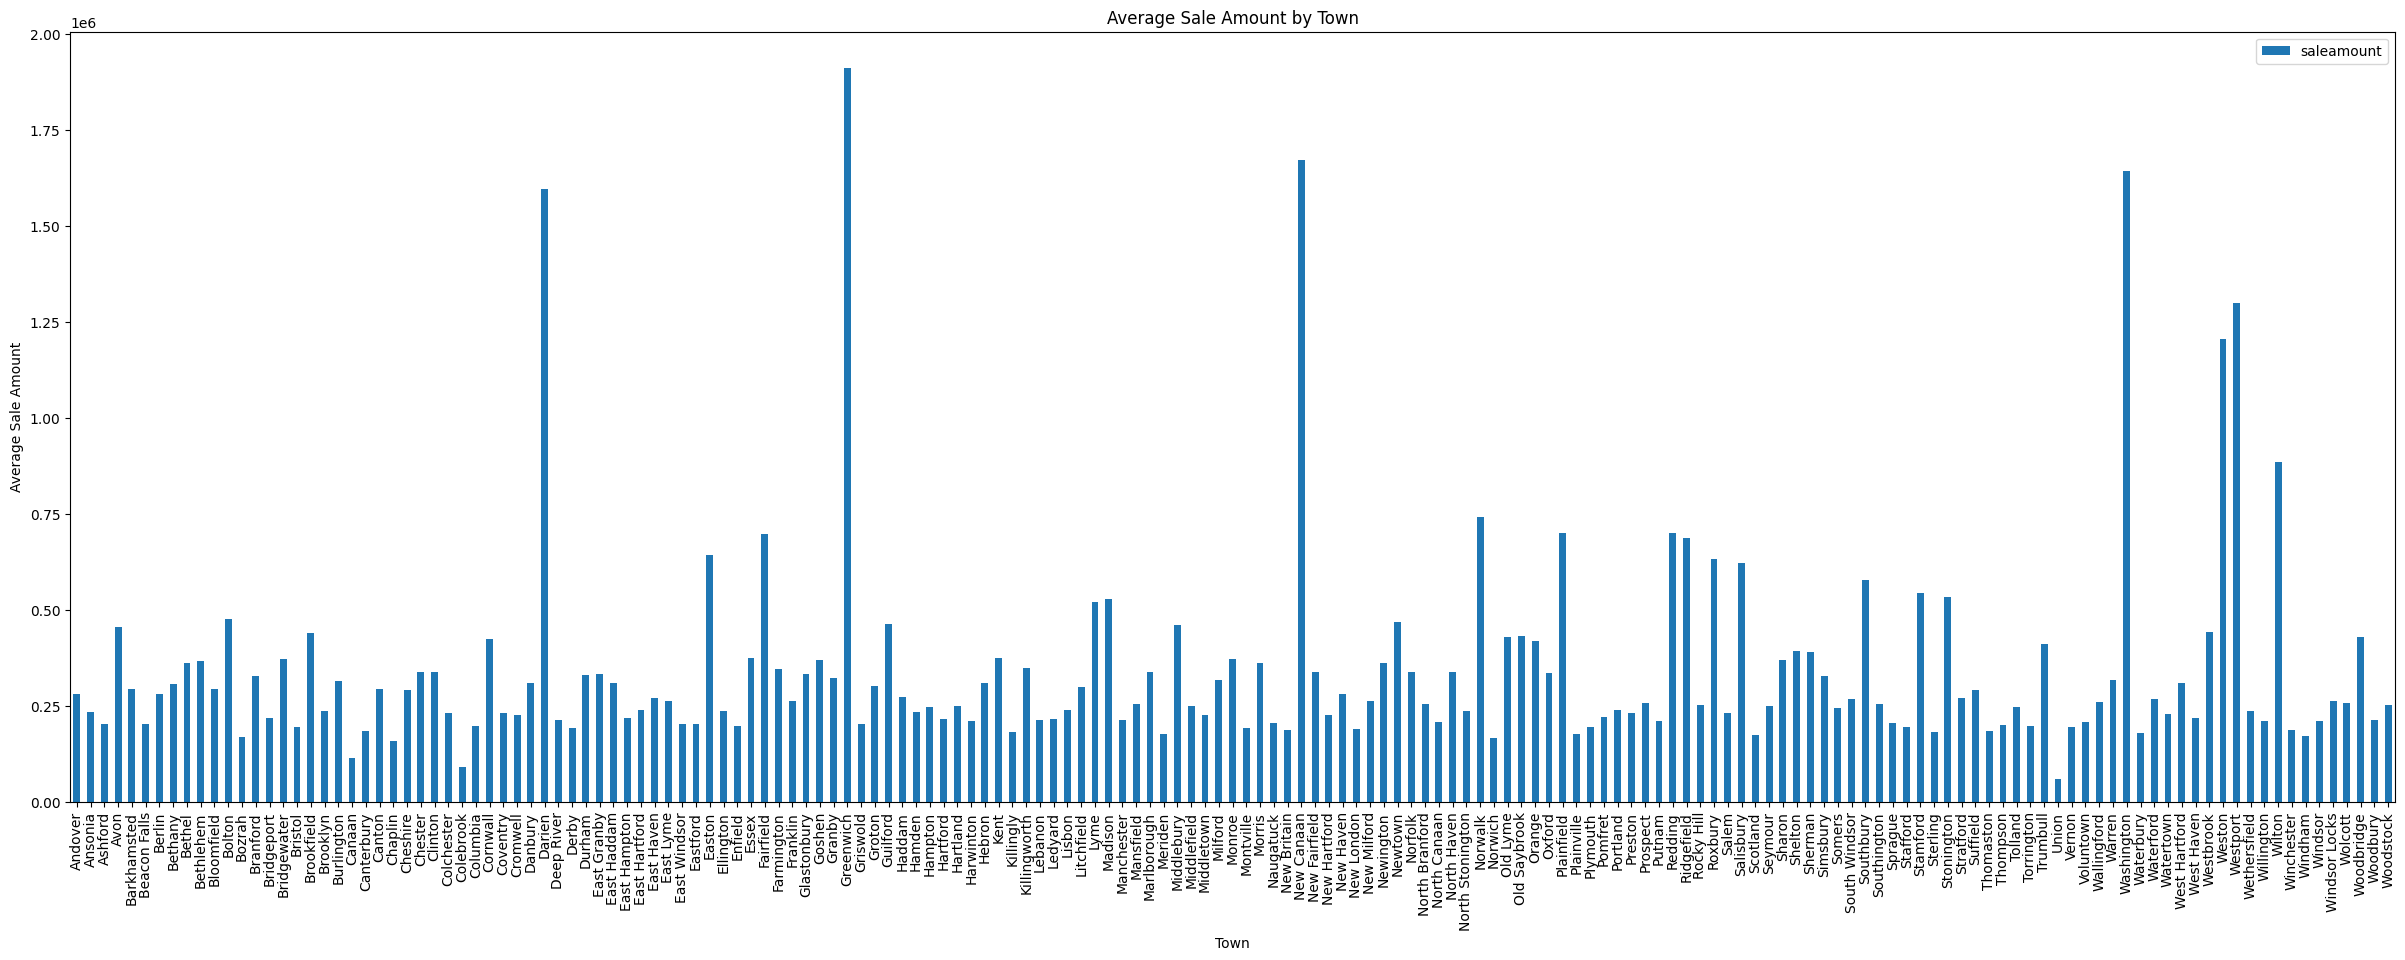

In [86]:
# make table with just town and saleamount columns
df3 = df_merge[['town', 'saleamount']]

# group by town and average the saleamount
df3 = df3.groupby('town').mean()

# remove the rows where town is '***Unknown***'
df3 = df3[df3.index != '***Unknown***']

df3.head()

# bar graph with town vs saleamount
df3.plot.bar(figsize=(30,10), title='Average Sale Amount by Town')
plt.xlabel('Town')
plt.ylabel('Average Sale Amount')
plt.show()

As we can see from the bar graph above, the average sales amount for homes in most towns is within the ranges of $200,000 and $400,000, a range that is shifted up from the average assessed values' range. From this graph, we can also observe that the towns with a signficantly higher average assessed value of homes, such as Darien, Greenwich, New Canaan, follow with the signficantly higher sales amounts as well.

Next, we graphed each unique town with its average sale ratio of houses, to get an overall assessment of the assessed value over sales amount of houses sold in each town.

/var/folders/04/hdjfckkd4fd__5521d_kggjh0000gn/T/ipykernel_53103/2815784812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['salesratio'] = df4['salesratio'].astype(float)


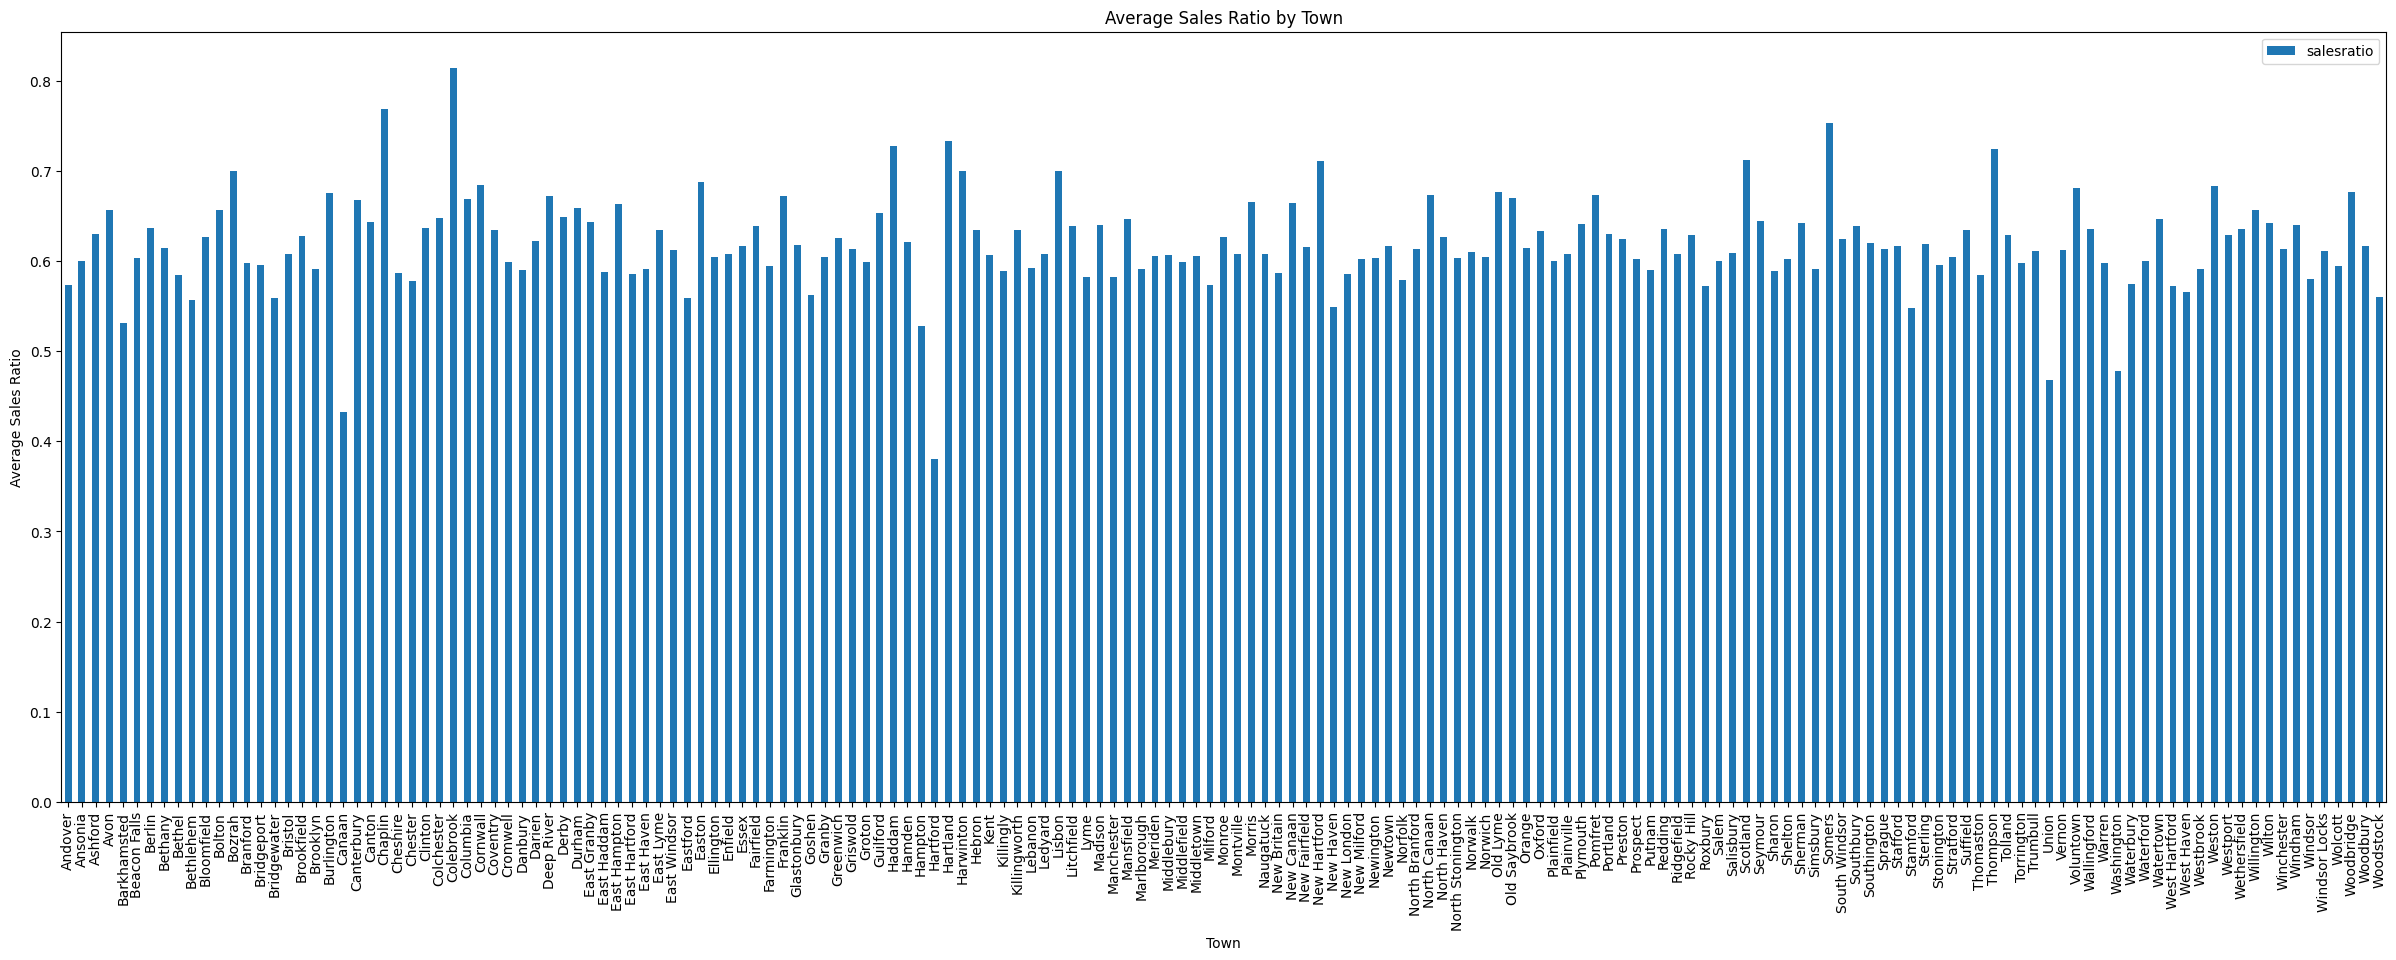

In [87]:
# make table with just town and salesratio columns
df4 = df_merge[['town', 'salesratio']]

# convert all salesratio values to floats
df4['salesratio'] = df4['salesratio'].astype(float)

# group by town and average the salesratio
df4 = df4.groupby('town').mean()

# remove the rows where town is '***Unknown***'
df4 = df4[df4.index != '***Unknown***']

df4.head()

# bar graph with town vs salesratio
df4.plot.bar(figsize=(30,10), title='Average Sales Ratio by Town')
plt.xlabel('Town')
plt.ylabel('Average Sales Ratio')
plt.show()

From the above bar graph, we see virtually no distinction between towns with higher assessed values or sale amounts, and their sales ratios, as almost all the towns have sales ratios that hover around 0.6. The one main outlier is with the town, Chester, which has an abnormally high sales ratio, and Hartford, which has an abnormally low sales ratio.

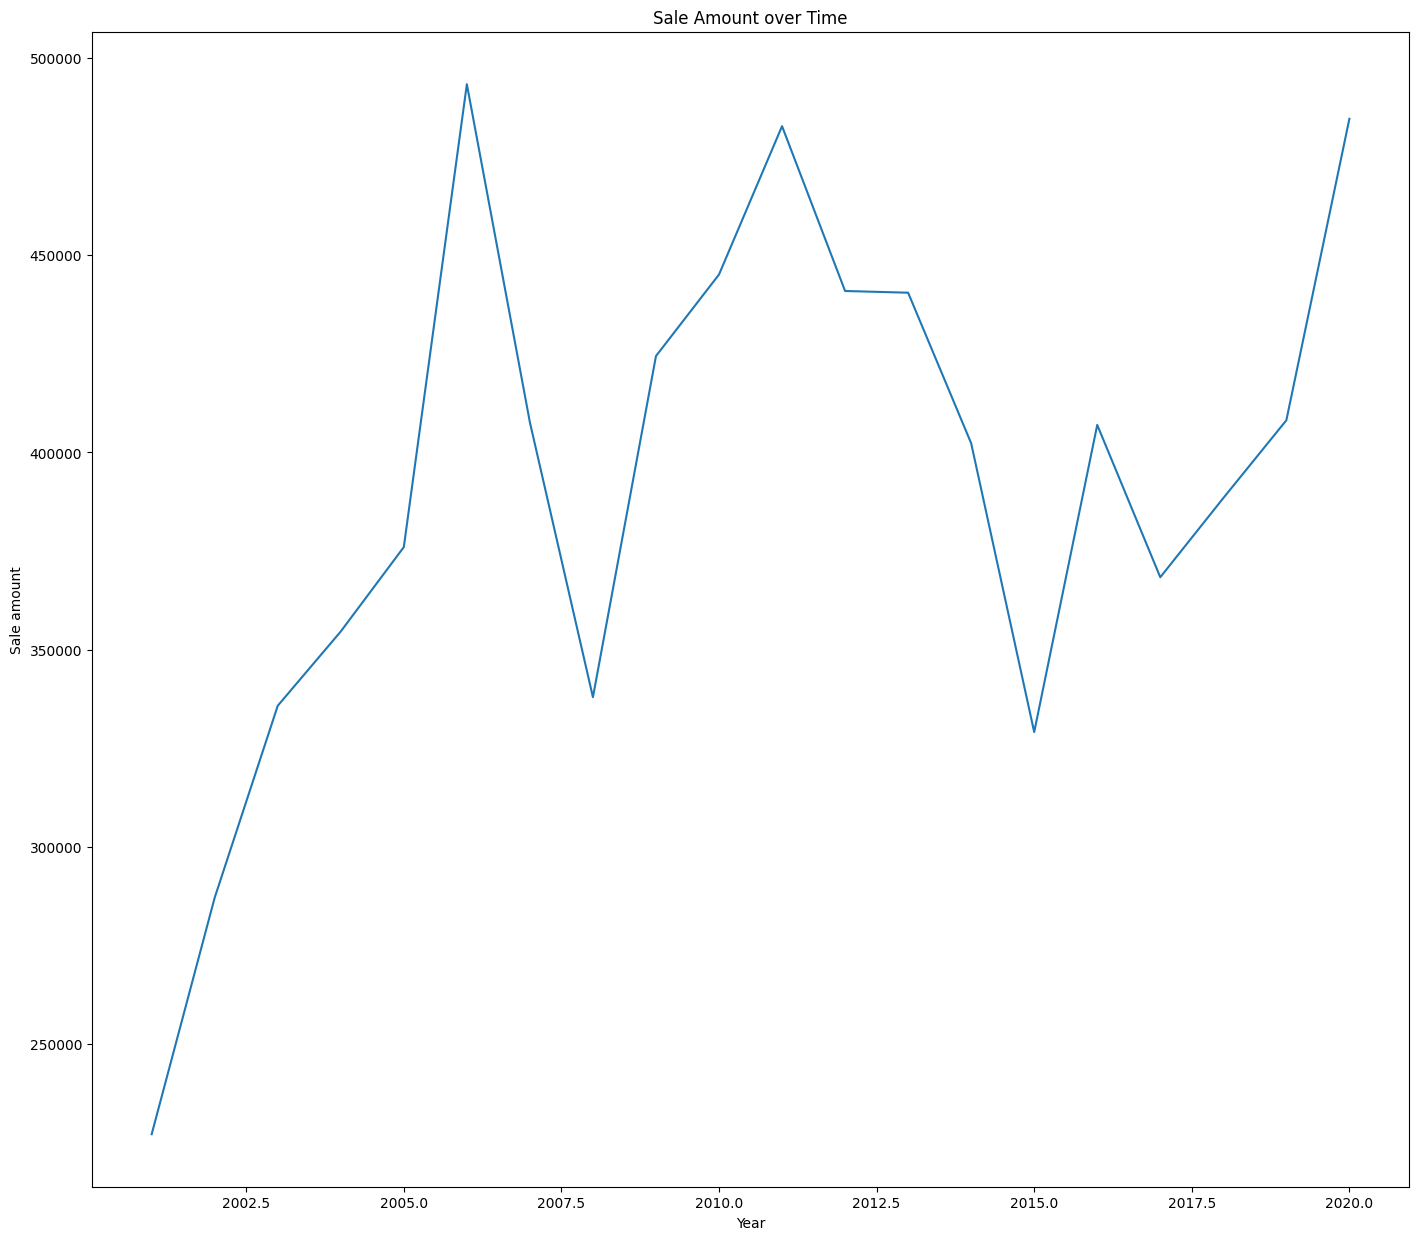

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Group the DataFrame by 'listyear' and calculate the mean 'saleamount'
grouped_df = df_merge.groupby('listyear')['saleamount'].mean()

# Get unique years
years = np.unique(df['listyear'])

plt.figure(figsize=(17, 15))
plt.plot(years, grouped_df.values)

plt.xlabel('Year')
plt.ylabel('Sale amount')
plt.title("Sale Amount over Time")

plt.show()

From the graph above, we can see that the housing market had a sharp and steady increase from 2001 to 2006 and dropped sharply afterwards. Then, the market peaked again in 2011 before hitting a low in 2015. Since 2015, the housing sale amounts have slowly increased and have not yet returned to the highest peak around 2006.

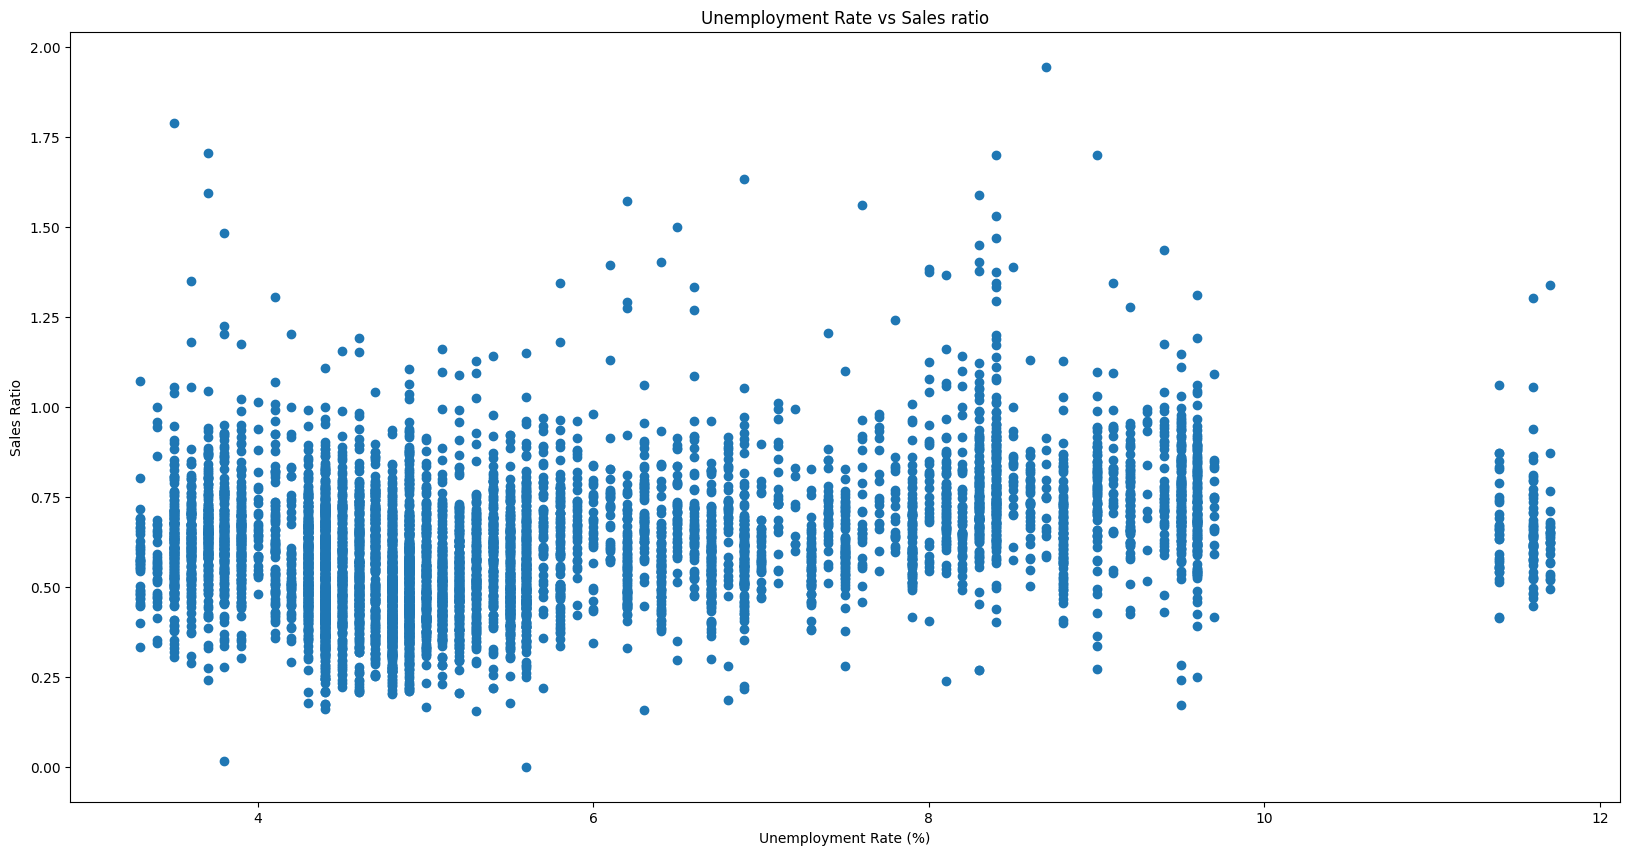

In [89]:
# unemployment rate
plt.figure(figsize=(20, 10))
plt.title("Unemployment Rate vs Sales ratio")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Sales Ratio")
# plt.ylim(0, 2.5)

plt.scatter(df_merge['UnemploymentRate'], df_merge['salesratio'])

In [90]:
from plotnine import *

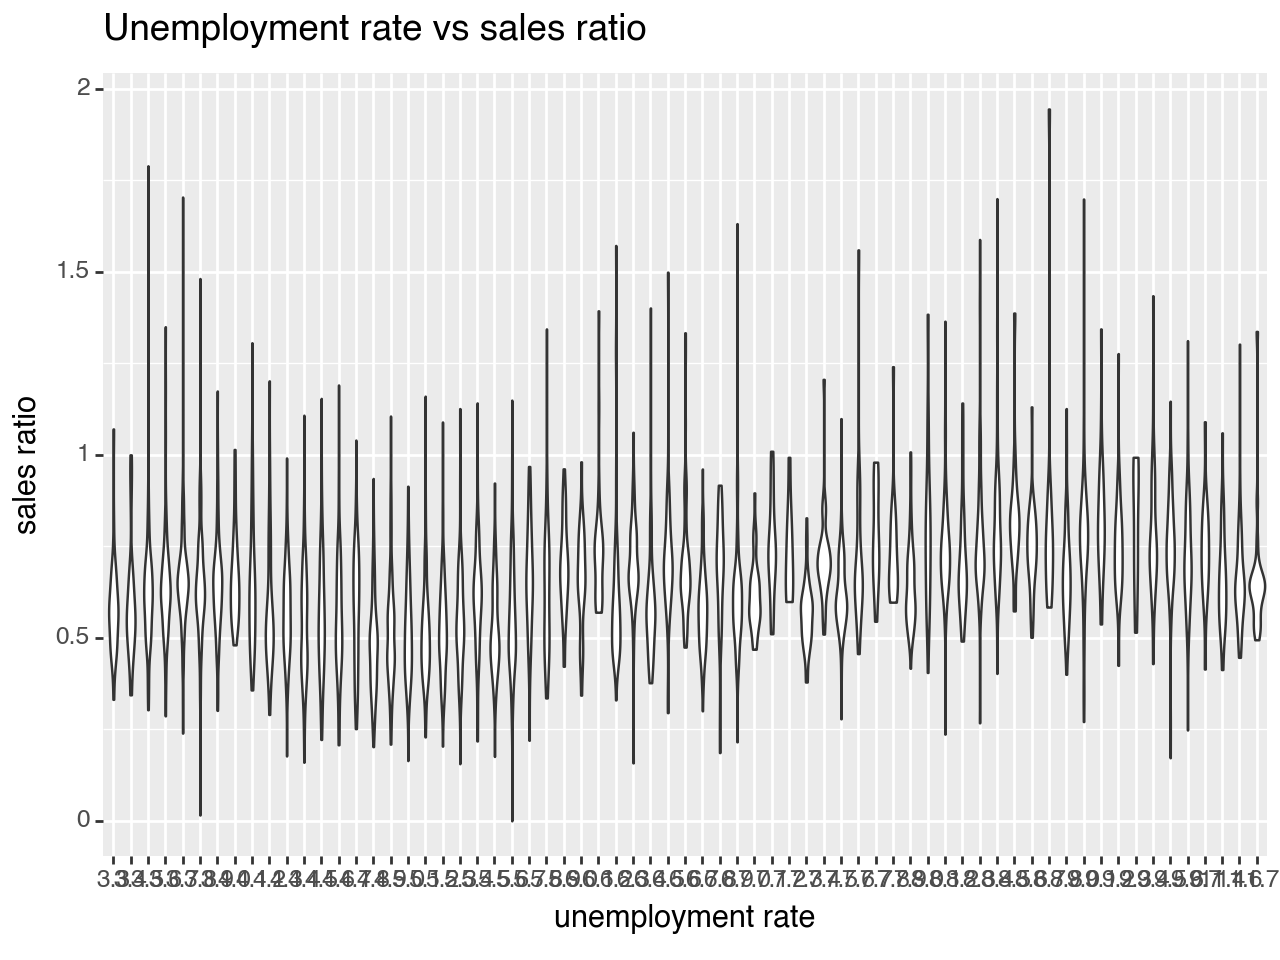

<Figure Size: (640 x 480)>

In [91]:
df = df_merge.copy()
df['UnemploymentRate'] = df['UnemploymentRate'].astype(object)
ggplot(data=df, mapping=aes(x='UnemploymentRate', y='salesratio')) +\
geom_violin() +\
labs(title="Unemployment rate vs sales ratio",
     x = "unemployment rate",
     y = "sales ratio") 

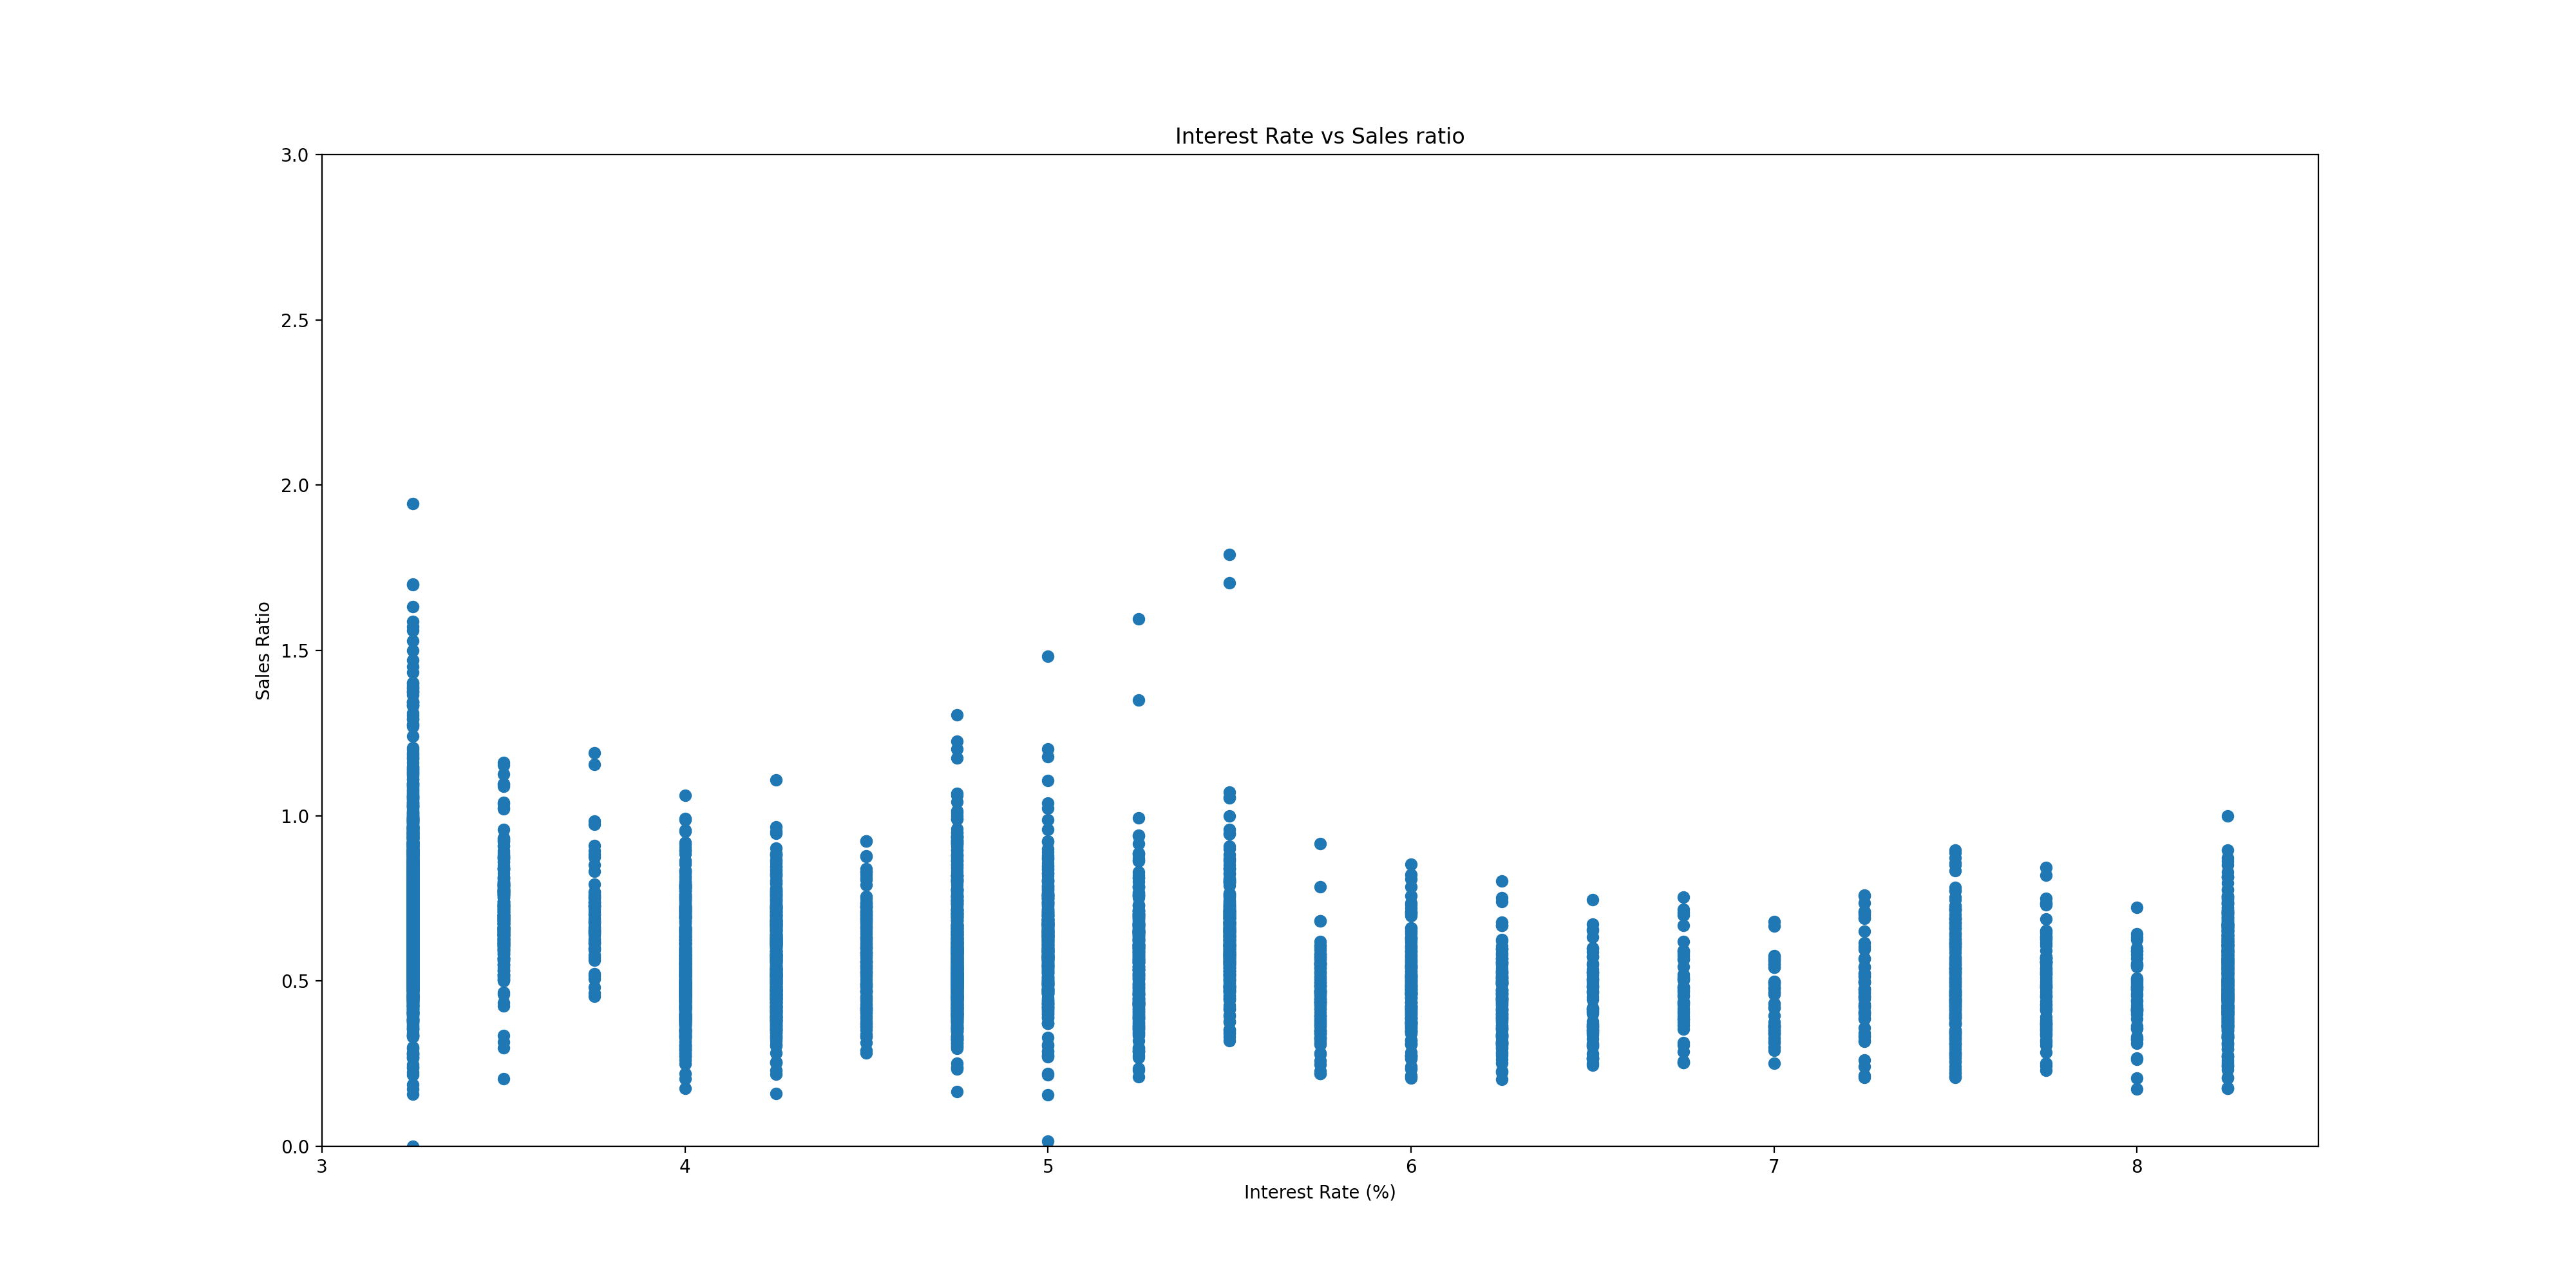

In [92]:
# unemployment rate
plt.figure(figsize=(20, 10))
plt.title("Interest Rate vs Sales ratio")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Sales Ratio")
plt.ylim(0, 3)

plt.scatter(df_merge['primeRate'], df_merge['salesratio'])

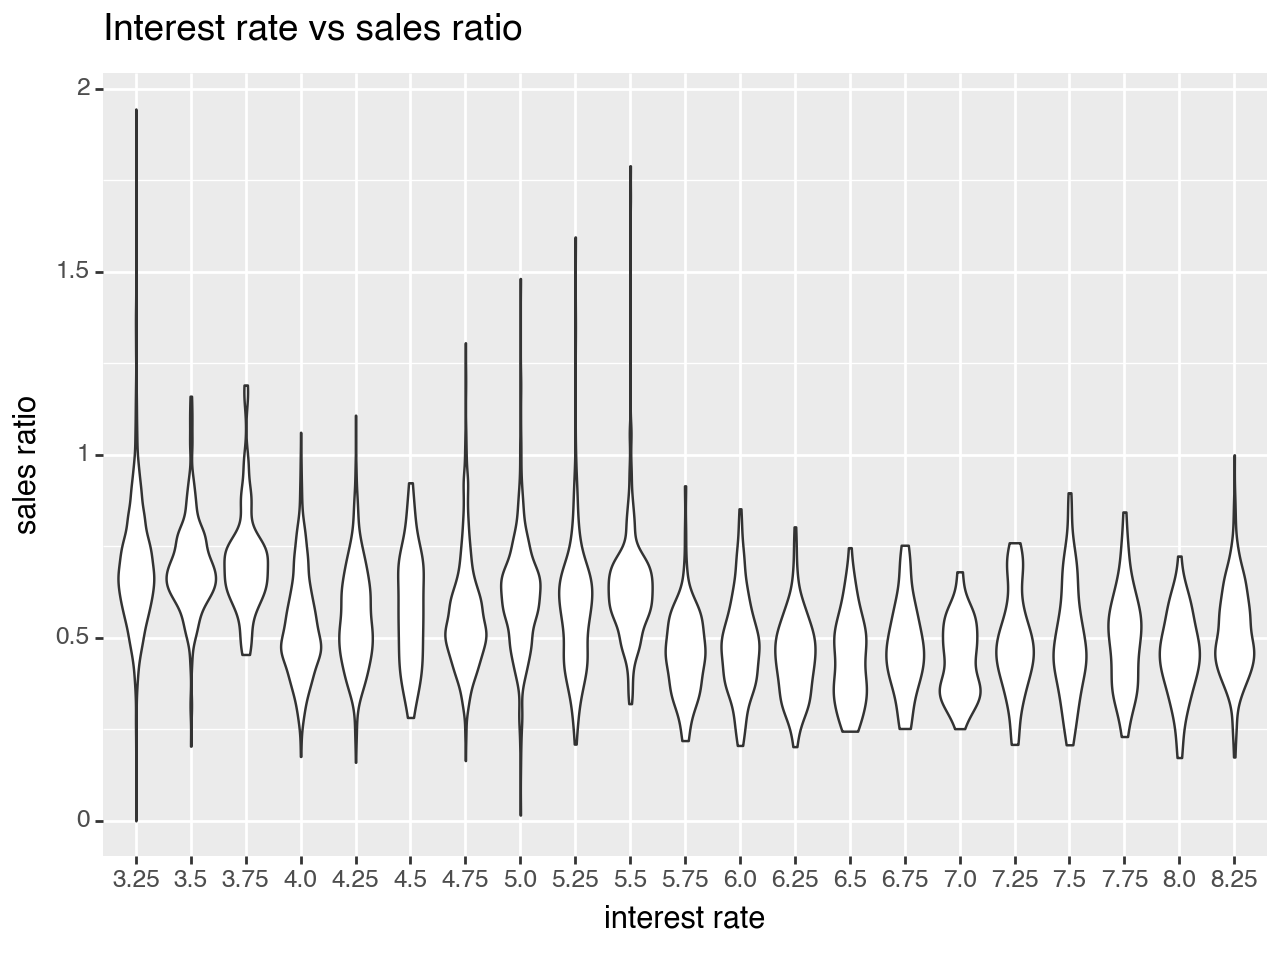

<Figure Size: (640 x 480)>

In [93]:
df = df_merge.copy()
df['primeRate'] = df['primeRate'].astype(object)
ggplot(data=df, mapping=aes(x='primeRate', y='salesratio')) +\
geom_violin() +\
labs(title="Interest rate vs sales ratio",
     x = "interest rate",
     y = "sales ratio") 

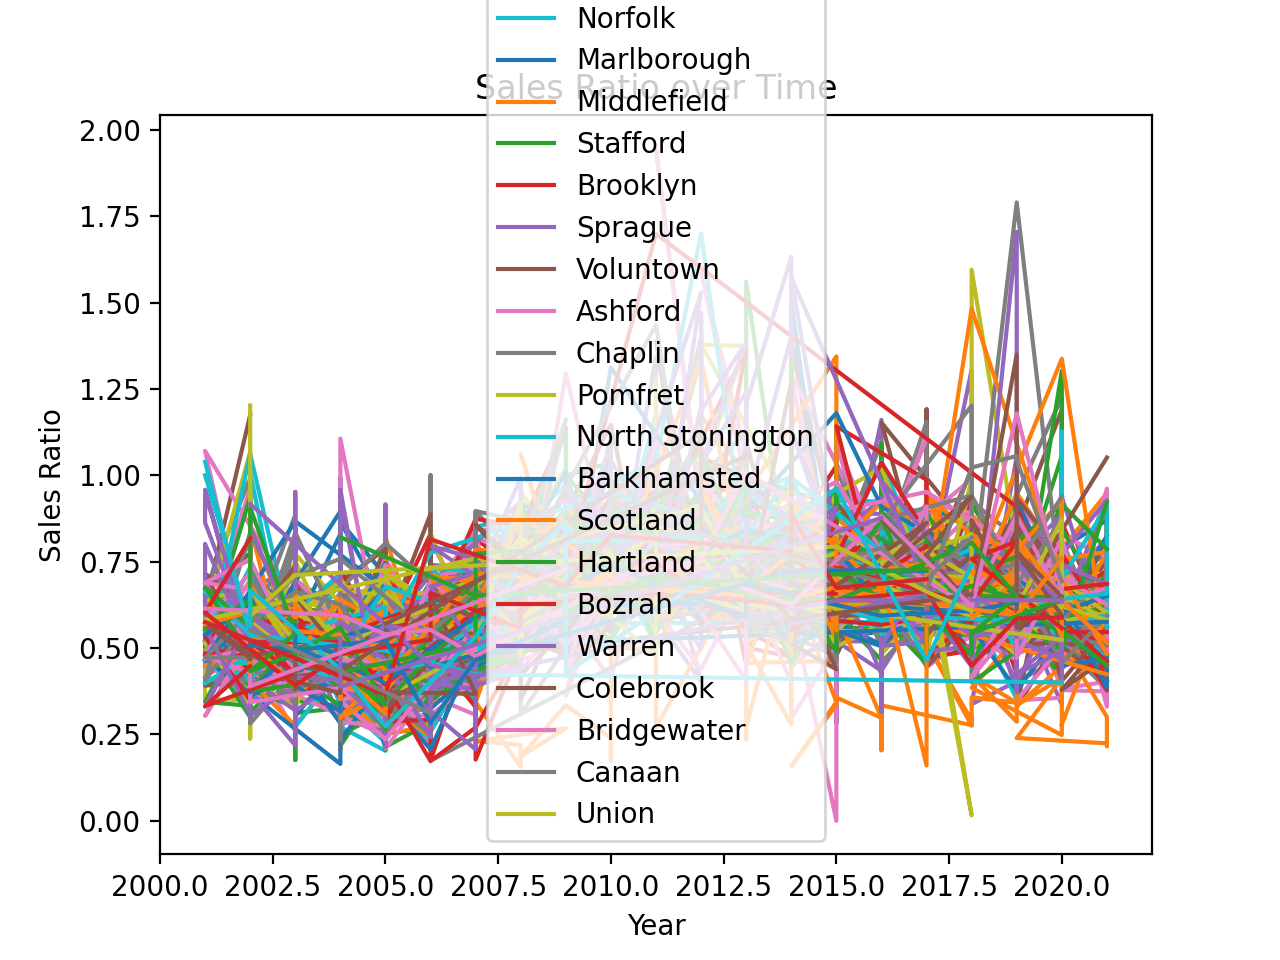

In [94]:
# plot each town's salesratio vs time onto a line graph
for town in df_merge['town'].unique():
    df_town = df_merge[df_merge['town'] == town]
    plt.plot(df_town['Year'], df_town['salesratio'], label=town)

plt.xlabel('Year')
plt.ylabel('Sales Ratio')
plt.title("Sales Ratio over Time")
plt.legend()
plt.show()

From the above line graph, we can again see each town's sales ratio, but now graphed against time / the year. We can see that each town's sales ratios tend to hover between 0.3 and 1.3 throughout 2001-2020. Also, the sales ratios for each town are more similar in value towards 2001, and vary more towards 2020.

We've been looking at real estate in Connecticut this whole time... so you might have been wondering where the maps were at! Well, here we go! We're going to make a map of each house's location, using its longitude (y_coord) and latitude (x_coord) values, and label each point/marker with its address name. This way, we can get a better visual of where houses are generally located in Connecticut.

In [95]:
import folium

# remove all rows with nan as x_coord or y_coord
df5 = df_merge.dropna(subset=['x_coord', 'y_coord'])\

# create a map centered on connecticut
m = folium.Map(location=[41.6, -72.7], zoom_start=9)

# plot all addresses on the map
for i, row in df5.iterrows():
    folium.CircleMarker(
        [row['y_coord'], row['x_coord']],
        radius=5,
        popup=row['address'],
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        tooltip=row['address']
    ).add_to(m)

m

## Step 4: Model: Analysis, Hypothesis Testing, Machine Learning

## Step 5: Interpretation: Insight & Policy Decision